# Project: Medical Treatment

# Problem Statement

Cancer tumor is caused by mutations of genes. These mutations normally happen in very large numbers such that it is very hard for Biomedical Scientist to really identify the mutation that can possibly lead to a cancer tumor.  To achieve this task, Biomedical Scientist classify these thousands of genetic mutations as to know which one could possibly lead to a cancer disease. This process takes a lot of time and it is prone to error. Hence, scientists need an automated way to classify genetic mutation and detect which one can result into cancer tumor.


To achieve this, all the previous/past knowledge base of the manual genetic mutation classification has been provided by the Memorial Sloan Kettering Cancer Center (MSKCC) (https://www.kaggle.com/c/msk-redefining-cancer-treatment) to Kaggle and was given out as a competition project for whoever was able to solve this problem with the highest precision. The cash prize for this competition was $ 15,000 .


# Analysis of the problem statement

Lets first understand the data set provided and using that dataset we will try to understand the above problem in Machine Learning world. Since, the dataset is huge lets load it using python itself

In [1]:
#Loading all required packages
#if any of it fails, do not panic. Just install it using "pip3 install <package_name>" or by using conda install package

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

There are 2 data files provided for solving this problem.

In [2]:
# Loading training_variants. Its a comma seperated file
data_variants = pd.read_csv('training/training_variants')
# Loading training_text dataset. This is seperated by ||
data_text = pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [3]:
data_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


Lets understand above data. There are 4 fields above:
    
    ID: row id used to link the mutation to the clinical evidence
    Gene: the gene where this genetic mutation is located
    Variation: the aminoacid change for this mutations
    Class: class value 1-9, this genetic mutation has been classified on 

In [4]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [5]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [6]:
# Checking dimension of data
data_variants.shape

(3321, 4)

In [7]:
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

Now lets explore about data_text

In [8]:
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


In [9]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [10]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [11]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [12]:
data_text.shape

(3321, 2)

So,in short my datasets looks like this
data_variants (ID, Gene, Variations, Class)
data_text(ID, text)

Okay, now we understood the dataset. Lets try to understand the same problem from Machine Learning point of view.

# Translating the Problem into Machine Learning World

In [13]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

This is descrete data so it is classification problem and since there are multiple descrete output possible so we can call it Multi class classification problem

In [14]:
# We would like to remove all stop words like "a", "is", "an", "the"
# so we collecting all of them from nltk library
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gsodipo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def data_text_preprocess(total_text, ind, col):
    # Remove int values from text data as that might not be imp
    if type(total_text) is not int:
        string = ""
        #replacing all special char with space
        total_text = re.sub('[^a-zA-z0-9\n]', ' ', str(total_text))
        # replacin multiple spaces with single space
        total_text = re.sub('\s+', ' ', str(total_text))
        #bring whole text to same lower-case scale.
        total_text = total_text.lower()
        
        for word in total_text.split():
            # if the word is not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        data_text[col][ind] = string

In [16]:
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

Lets merge both the dataset using the common column - ID

In [17]:
#merging both gene_variation and text data based on ID
result = pd.merge(data_variants, data_text, on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


it is very important to look for missing values. Else they create problem in final analysis

In [18]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


We can see many rows with missing data. Now the question is what to do with this missing value. One way could be that we can drop these rows havin
missing values or we can do some imputation in  it. Let's go with imputation only. But question is what to impute here:

How about merging Gene and Variation column. Let's do it:

In [19]:
result.loc[result['TEXT'].isnull(),'TEXT']= result['Gene'] + ' '+result['Variation']

Let's cross check it once again if ther is any missing number

In [20]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


Awesome, so all missing values are gone now.

# Creating Training, Text and Validation data

Before we split the data into training, test and validation data set. We want to ensure that all spaces in Gene and Variation column to be replaced by _.

In [21]:
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+','_')
result.Validation = result.Variation.str.replace('\s+', '_')

Splitting the  dataset into  train, test and validation data set

In [22]:
# Splitting the data into train and text set
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
#Split the train data now into train validation and cross validation
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [23]:
print("Number of data points in train data: ", train_df.shape[0])
print("Number of data points in test data: ",test_df.shape[0])
print("Number of data points in cross validation data:", cv_df.shape[0])

Number of data points in train data:  2124
Number of data points in test data:  665
Number of data points in cross validation data: 532


Number of data points in cross validation data: 532
    
looking at the distribution of data in train, test and validation set.


In [24]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

In [25]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

So the above means that in the train dataset we have class 1 values with count of 363, class 2 values having count of 289 and so on. it will be better idea to visualize it in graph format

#### Visualizing for train class distribution

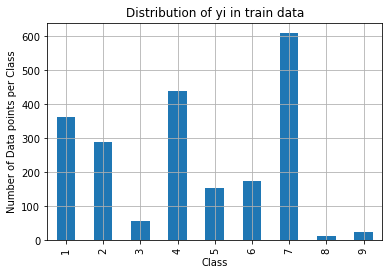

In [26]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel("Number of Data points per Class")
plt.title("Distribution of yi in train data")
plt.grid()
plt.show()

Let's look at distribution in for of percentage

In [27]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print("Number of data points in class", i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100))," % )")

Number of data points in class 7 : 609 ( 29.0  % )
Number of data points in class 4 : 439 ( 21.0  % )
Number of data points in class 1 : 363 ( 17.0  % )
Number of data points in class 2 : 289 ( 14.0  % )
Number of data points in class 6 : 176 ( 8.0  % )
Number of data points in class 5 : 155 ( 7.0  % )
Number of data points in class 3 : 57 ( 3.0  % )
Number of data points in class 9 : 24 ( 1.0  % )
Number of data points in class 8 : 12 ( 1.0  % )


Let's visualize the same for test set

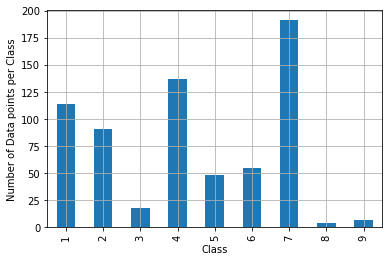

In [28]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel("Number of Data points per Class")
plt.grid()
plt.show()

In [29]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':', test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100))," % )")

Number of data points in class 7 : 191 ( 29.0  % )
Number of data points in class 4 : 137 ( 21.0  % )
Number of data points in class 1 : 114 ( 17.0  % )
Number of data points in class 2 : 91 ( 14.0  % )
Number of data points in class 6 : 55 ( 8.0  % )
Number of data points in class 5 : 48 ( 7.0  % )
Number of data points in class 3 : 18 ( 3.0  % )
Number of data points in class 9 : 7 ( 1.0  % )
Number of data points in class 8 : 4 ( 1.0  % )


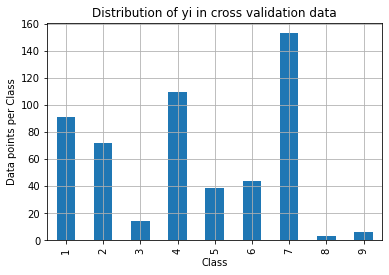

In [30]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

In [31]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':', cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100))," % )")

Number of data points in class 7 : 153 ( 29.0  % )
Number of data points in class 4 : 110 ( 21.0  % )
Number of data points in class 1 : 91 ( 17.0  % )
Number of data points in class 2 : 72 ( 14.0  % )
Number of data points in class 6 : 44 ( 8.0  % )
Number of data points in class 5 : 39 ( 7.0  % )
Number of data points in class 3 : 14 ( 3.0  % )
Number of data points in class 9 : 6 ( 1.0  % )
Number of data points in class 8 : 3 ( 1.0  % )


Now the question is because we need log-loss as final evaluation metrics how do we say that model we are going to build will be good model. For doing this we will build a random model and will evaluate log loss. Ourmodel should return lower log loss
value than this. 

# Building a Random Model

 Okay, so we need to generate 9 random numbers because we have 9 class such that their sum must be equak to 1 because Probability of all 9 classes must be equvalent to 1

In [32]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [33]:
# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs))))[0]
print("Log loss on Cross Validation Data using Random Model", log_loss(y_cv,cv_predicted_y, eps=1e-15))

Log loss on Cross Validation Data using Random Model 2.406539407138889


In [34]:
# Test-Set error.
# we create a output array that has exactly same as the test data.
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs))))[0]
print("Log loss on Test Data using Random Model", log_loss(y_test, test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.4905970587678716


In [35]:
# Lets get the index of max probability
predicted_y = np.argmax(test_predicted_y, axis = 1)

In [36]:
# Lets see the output. These will be 665 values present in the test dataset
predicted_y

array([3, 8, 1, 4, 5, 4, 5, 7, 2, 6, 7, 5, 4, 8, 2, 5, 1, 7, 6, 1, 4, 5,
       1, 6, 6, 7, 3, 8, 8, 8, 3, 1, 7, 7, 8, 3, 6, 3, 5, 8, 7, 4, 0, 7,
       0, 8, 5, 7, 2, 3, 5, 5, 7, 6, 1, 5, 4, 0, 3, 2, 8, 7, 8, 6, 2, 2,
       2, 7, 7, 8, 4, 1, 1, 8, 2, 1, 3, 1, 7, 0, 5, 0, 7, 6, 3, 3, 7, 5,
       3, 6, 7, 6, 3, 7, 8, 3, 3, 5, 4, 1, 0, 5, 5, 4, 7, 2, 2, 5, 2, 3,
       7, 1, 6, 3, 1, 0, 7, 3, 5, 8, 5, 0, 7, 1, 4, 2, 5, 5, 7, 3, 3, 5,
       7, 3, 1, 2, 5, 0, 5, 3, 7, 6, 7, 7, 6, 4, 3, 2, 0, 7, 6, 7, 3, 5,
       4, 4, 2, 2, 3, 6, 7, 3, 4, 8, 2, 7, 3, 4, 7, 1, 4, 8, 0, 0, 7, 0,
       4, 3, 3, 3, 8, 4, 2, 3, 1, 3, 4, 3, 6, 3, 7, 2, 4, 0, 4, 5, 1, 4,
       2, 4, 6, 1, 4, 7, 8, 0, 1, 0, 5, 4, 5, 0, 8, 8, 4, 4, 8, 8, 0, 5,
       2, 7, 8, 8, 2, 4, 7, 6, 0, 4, 5, 6, 1, 6, 8, 0, 3, 6, 2, 8, 3, 5,
       4, 3, 4, 8, 5, 7, 7, 6, 3, 2, 4, 5, 7, 3, 2, 8, 1, 6, 1, 5, 4, 2,
       8, 7, 4, 3, 3, 5, 0, 8, 8, 5, 7, 4, 5, 6, 7, 3, 4, 2, 2, 5, 2, 0,
       7, 6, 4, 8, 4, 8, 3, 4, 1, 2, 0, 3, 7, 5, 2,

So you can see the index value ranging from 0 to 8. So, lets make it as 1 to 9 we will increase this value by 1.

In [37]:
predicted_y = predicted_y + 1

# Confusion Matrix

In [38]:
C = confusion_matrix(y_test, predicted_y)

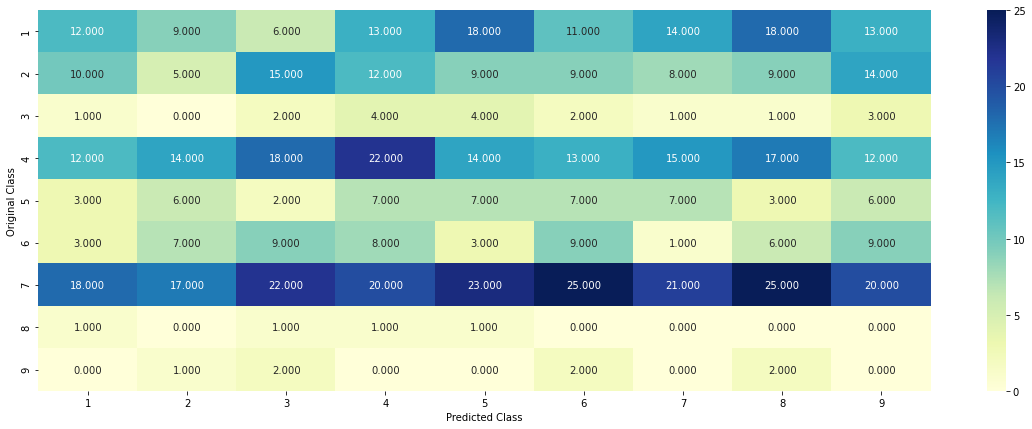

In [39]:
labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

# Precision matrix

In [40]:
B = (C/C.sum(axis=0))

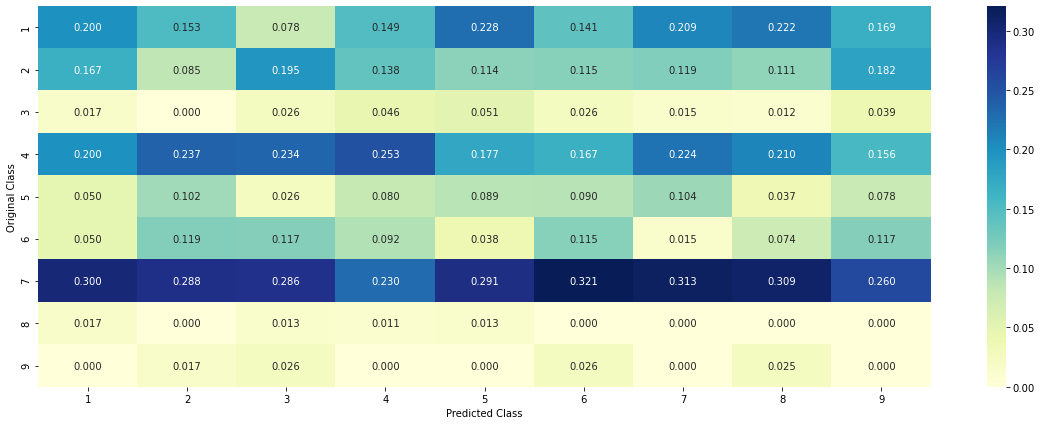

In [41]:
plt.figure(figsize = (20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

# Recall

In [42]:
A = (((C.T)/(C.sum(axis=1))).T)

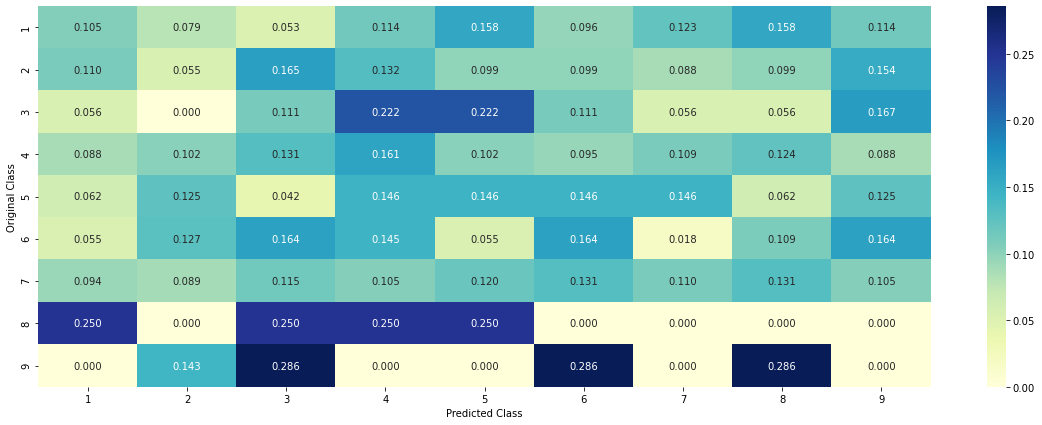

In [43]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

# Evaluating Gene Column

Now we will look at each independent column to make sure its relavant for the target variable but the question is, how? We can understand this with our first column Gene which is categorical in nature.


So lets explore column Gene and lets look at its distribution

In [44]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])

# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 233
BRCA1     171
TP53      108
EGFR       97
PTEN       78
BRCA2      72
KIT        67
BRAF       50
ERBB2      48
ALK        41
PIK3CA     40
Name: Gene, dtype: int64


Lets see the number of unique values present in gene

In [45]:
unique_genes.shape[0]

233

Lets look at the commulative distribution of unique Genes values

<function matplotlib.pyplot.show(close=None, block=None)>

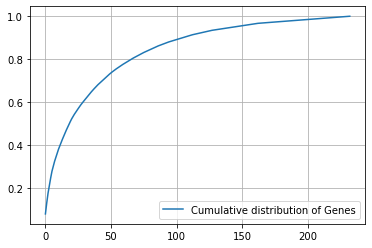

In [46]:
S = sum(unique_genes.values)
h = unique_genes.values/S
c = np.cumsum(h)
plt.plot(c, label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show

So, now we need to convert these categorical variable to appropriate format which my machine learning algorithm will be able to take as an input.

So we have 2 techniques to deal with it:

1. One-hot encoding
2. Response Encoding (Mean imputation)

Let's use both of them to see which one work the best. So lets start encoding using one hot encoder.

In [47]:
# One-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

Lets check the number of column generated after one hot encoding. One hot encoding will always return higher number of column.

In [48]:
train_gene_feature_onehotCoding.shape

(2124, 233)

In [49]:
# column names after one-hot encoding for Gene Column
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl2',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axl',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxo1',
 'fubp1',
 'gata3',
 'gli1',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikzf1',
 'il7

Now, lets create Response encoding columns for Gene column

In [50]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ------------------
# Consider all unique values and the number of occurences of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in  class1 + 10*alpha / number of time it occured)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of  it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# -----------------------------------------

#get_gv_fea_dict: Get Gene variation Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    #value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #    {BRCA1          174
    #     TP53           106
    #     EGFR            86
    #     BRCA2           75
    #     PTEN            69
    #     KIT             61
    #     BRAF            60
    #     ERBB2           47
    #     PDGFRA          46
    #    ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                    63
    # Deletion                                43
    # Amplification                           43
    # Fusions                                 22
    # Overexpression                           3
    # E17K                                     3
    # Q61L                                     3
    # S222D                                    2
    # P130S                                    2
    # ...
    #}
    value_counts = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_counts.items():
        # vec will contain (P(yi=1/Gi)) probability of gene/variation belongs to particular class
        # vec is 9 dimensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class'] == 1) & (train_df['Gene'] == 'BRCA1')])
            #           ID      Gene                  Variation     Class
            # 2470    2470      BRCA1                   S1715C          1
            # 2486    2486      BRCA1                   S1841R          1
            # 2614    2614      BRCA1                   M1R             1
            # 2432    2432      BRCA1                   L1657P          1
            # 2567    2567      BRCA1                   T1685A          1
            # 2583    2583      BRCA1                   E1660G          1
            # 2634    2634      BRCA1                   W1718L          1
            # cls_cnt.shape[0] will return the number of rows
            
            cls_cnt = train_df.loc[(train_df['Class'] ==k) & (train_df[feature] == i)]
            
            #cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole dataset
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
            
        #we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i] = vec
    return gv_dict

#Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    #value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    #gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add it
    #if not we will add  [1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
    
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,1,-1])
    return gv_fea

In [51]:
#response-coding of the Gene feature
#alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
#test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
#cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

Let's look at columns after applying response encoding. We must be having 9 columns for Gene column after response encoding.

In [52]:
train_gene_feature_responseCoding.shape

(2124, 9)

Now, question is: how good is Gene feature to predict the 9 classes. One idea could be that we will build model having only gene column with one hot encoder with simple model like Logistic regression. if log loss with only one column Gene comes out to be better than random model, than this feature is important

In [53]:
# We need a hyperparameter for SGD classifier
alpha = [10 ** x for x in range(-5,1)]

In [54]:
# we will be using SGD classifier
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifer.html
# We will also be using Caliberated Classifier to get the result into probability format t be used for log loss

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print("For values of alpha = ", i, "The log loss is:", log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.1697737656078886
For values of alpha =  0.0001 The log loss is: 1.13931266340987
For values of alpha =  0.001 The log loss is: 1.1763209244732302
For values of alpha =  0.01 The log loss is: 1.3101956389876375
For values of alpha =  0.1 The log loss is: 1.4647962675237924
For values of alpha =  1 The log loss is: 1.5145974997132663


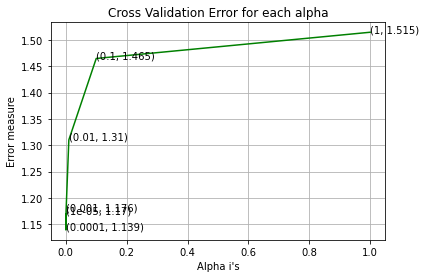

In [55]:
# Lets plot the same to check the best Alpha value

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [56]:
# Lets use best alpha value as we can see from above graph and compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ',alpha[best_alpha], "The train log loss is : ", log_loss(y_train,predict_y, labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ',alpha[best_alpha], "The cross validation log loss is : ", log_loss(y_cv,predict_y, labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ',alpha[best_alpha], "The test log loss is : ", log_loss(y_test,predict_y, labels=clf.classes_,eps=1e-15))

For values of best alpha =  0.0001 The train log loss is :  1.0057352837181157
For values of best alpha =  0.0001 The cross validation log loss is :  1.13931266340987
For values of best alpha =  0.0001 The test log loss is :  1.207967115224697


Now lets check how many values are overlapping between train, test or between CV and train

In [57]:
test_coverage = test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [58]:
print('1. In test data', test_coverage, 'out of', test_df.shape[0], ":", (test_coverage/test_df.shape[0])*100)
print('2. In cross validation data', cv_coverage, 'out of ', cv_df.shape[0], ":" ,(cv_coverage/cv_df.shape[0]) * 100)

1. In test data 639 out of 665 : 96.09022556390977
2. In cross validation data 520 out of  532 : 97.74436090225564


# Evaluation on Variation Column

Variation is also a categorical variable so we have to deal in the same way like we have done for Gene column. We will again get the one hot encoder and response encoding variable for variation column

In [59]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
#the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1932
Truncating Mutations    62
Deletion                43
Amplification           43
Fusions                 22
Overexpression           4
Q61R                     3
V321M                    2
G12V                     2
Q22K                     2
E330K                    2
Name: Variation, dtype: int64


Lets look at the cummulative distribution of unique variation values

[0.02919021 0.04943503 0.06967985 ... 0.99905838 0.99952919 1.        ]


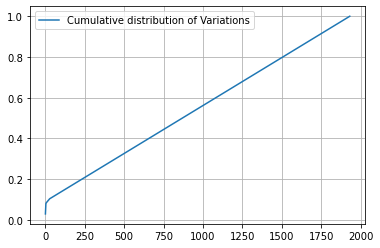

In [60]:
s = sum(unique_variations.values);
h = unique_variations.values/s
c = np.cumsum(h)
print(c)
plt.plot(c, label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

Lets convert the variation column using one hot encoder column

In [61]:
# one-hot encoding of variation feature
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

Lets look at shape of one hot encoder column for variation

In [62]:
train_variation_feature_onehotCoding.shape

(2124, 1962)

Lets do the  same for  variation column and generate response encoding for  the same

In [63]:
# alpha is used for laplace smoothing
alpha = 1
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
#cross validation gene feature

cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

Lets look at the shape of this response encoding result

In [64]:
train_variation_feature_responseCoding.shape

(2124, 9)

Lets again build the model with only column name of variation column

In [65]:
# we need a hyperparameter for SGD classifier
alpha = [10 ** x for x in range(-5,1)]

In [68]:
# we will be using SGD classifier
# http.scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# We will also be using Caliberated Classifier to get the result into probability format t be used for log loss

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is : ",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is :  1.7271814407471144
For values of alpha =  0.0001 The log loss is :  1.7194667531712093
For values of alpha =  0.001 The log loss is :  1.7180514204685966
For values of alpha =  0.01 The log loss is :  1.7258304645787452
For values of alpha =  0.1 The log loss is :  1.7350468086353221
For values of alpha =  1 The log loss is :  1.7360665801837698


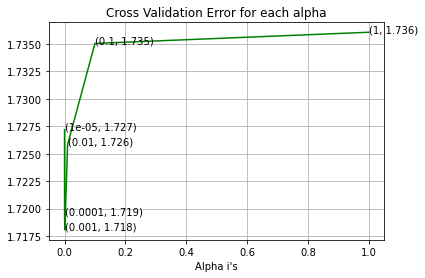

In [69]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.show()

In [70]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss = 'log', random_state = 42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

For values of best alpha =  0.001 The train log loss is:  1.226293279669908
For values of best alpha =  0.001 The cross validation log loss is:  1.7180514204685966
For values of best alpha =  0.001 The test log loss is:  1.6650090609478791


In [71]:
test_coverage = test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [72]:
print("1. In test data", test_coverage, 'out of', test_df.shape[0], ":", (test_coverage/test_df.shape[0]) * 100)
print("2. In cross validation data", cv_coverage, 'out of ', cv_df.shape[0], ":", (cv_coverage/cv_df.shape[0])*100)

1. In test data 85 out of 665 : 12.781954887218044
2. In cross validation data 45 out of  532 : 8.458646616541353


# Evaluating Text Column

In [73]:
# cls_text is a data frame
# for every row in data frame consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [79]:
import math

#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10)/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index +=1
    return text_feature_responseCoding

In [80]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names()

#train text feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1 * number of features) vector.
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis = 0).A1

#zip(list(text_features), text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53518


In [81]:
dict_list = []
# dict_list = [] contains 9 dictionaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class'] == i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list
    
# dict_list[i] is build on i'th class text data
# total_dict is build on whole training text data
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i] + 10) / (total_dict[i] + 90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [83]:
# response coding of text features
train_text_feature_responseCoding = get_text_responsecoding(train_df)
test_text_feature_responseCoding = get_text_responsecoding(test_df)
cv_text_feature_responseCoding = get_text_responsecoding(cv_df)

In [84]:
#https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [85]:
# don't foget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
#don't forget to normalize every feature

test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis = 0)

In [87]:
#https://stackoverflow.com/a/2258273/4084039

sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x:x[1], reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [88]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5114, 4: 3785, 6: 2989, 5: 2565, 8: 2096, 9: 2022, 7: 1936, 10: 1348, 12: 1254, 11: 1234, 13: 1029, 14: 937, 15: 916, 16: 867, 18: 725, 17: 633, 20: 572, 22: 549, 19: 514, 24: 481, 23: 453, 21: 446, 26: 413, 30: 379, 27: 377, 41: 369, 25: 353, 28: 352, 29: 334, 49: 290, 33: 284, 32: 279, 31: 275, 36: 273, 34: 263, 35: 240, 42: 217, 40: 214, 39: 214, 45: 209, 44: 199, 38: 191, 37: 191, 43: 186, 46: 170, 48: 166, 52: 155, 58: 154, 50: 149, 56: 148, 60: 143, 47: 137, 51: 136, 54: 133, 66: 132, 55: 132, 57: 129, 59: 123, 53: 123, 61: 116, 63: 114, 68: 111, 69: 109, 64: 104, 65: 100, 82: 98, 62: 96, 73: 95, 72: 94, 84: 92, 71: 91, 77: 90, 70: 90, 75: 85, 90: 84, 76: 81, 98: 80, 78: 78, 79: 77, 67: 77, 81: 76, 88: 75, 93: 71, 91: 70, 86: 69, 80: 69, 89: 67, 87: 64, 85: 64, 74: 64, 99: 63, 83: 63, 92: 62, 104: 59, 97: 58, 112: 55, 111: 55, 100: 55, 123: 54, 108: 54, 95: 54, 96: 52, 120: 50, 105: 49, 101: 49, 102: 48, 126: 46, 119: 46, 118: 46, 110: 46, 129: 45, 122: 45, 140: 44, 1

Lets build the model with only text column

In [90]:
cv_log_error_error = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print("For values of alpha = ", i, "The log loss is: ",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is:  1.277324557962712
For values of alpha =  0.0001 The log loss is:  1.1545381111137383
For values of alpha =  0.001 The log loss is:  1.1352287060469974
For values of alpha =  0.01 The log loss is:  1.2266065198210407
For values of alpha =  0.1 The log loss is:  1.4285022138991603
For values of alpha =  1 The log loss is:  1.6059053974316284


In [92]:
# fig, ax = plt.subplots()
# ax.plot(alpha, cv_log_error_array, c='g')
# for i, txt in enumerate(np.round(cv_log_error_array, 3)):
#     ax.annotate((alpha[i], np.round(txt,3)), (alpha[i], cv_log_error_array[i]))
# plt.grid()
# plt.title("Cross Validation Error for each alpha")
# plt.xlabel("Alpha i's")
# plt.ylabel("Error measure")
# plt.show()

In [94]:
# best_alpha = np.argmin(cv_log_error_array)
# clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
# clf.fit(train_text_feature_onehotCoding, y_train)
# sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
# sig_clf.fit(train_text_feature_onehotCoding, y_train)


# predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
# print("For values of best alpha = ", alpha[best_alpha], "The train log loss is: ",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
# predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
# print("For values of best alpha = ", alpha[best_alpha], "The cross validation log loss is: ",log_loss(y_cv,predict_y,labels=clf.classes_, eps=1e-15))
# predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
# print('For values of best alpha = ', alpha[best_alpha], "The test log loss is: ",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Let's check the overlap of text data

In [95]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()
    
    df_text_fea_counts = df_text_fea.sum(axis = 0).A1
    df_text_fea_dict = dict(zip(list(df_text_features), df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1, len2

In [96]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1) * 100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1) * 100,3), "% of word of Cross Validation appeared in train data")

96.735 % of word of test data appeared in train data
97.993 % of word of Cross Validation appeared in train data


so, all 3 columns are going to be important

# Data Preparation for Machine Learning Models

Lets create few functions which we will be using later

In [98]:
def report_log_loss(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [99]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [100]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

# Combining all 3 features together

In [101]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [102]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55713)
(number of data points * number of features) in test data =  (665, 55713)
(number of data points * number of features) in cross validation data = (532, 55713)


In [103]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


# Building Machine Learning model

Lets start the first model which is most suitable when we have lot of text column data. So, we will start with Naive Bayes.

# Naive Bayes

In [104]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.2645744582969174
for alpha = 0.0001
Log Loss : 1.2575008356353174
for alpha = 0.001
Log Loss : 1.2561526768718738
for alpha = 0.1
Log Loss : 1.2455465734799718
for alpha = 1
Log Loss : 1.2874308615265249
for alpha = 10
Log Loss : 1.4118813518161146
for alpha = 100
Log Loss : 1.3940809944813106
for alpha = 1000
Log Loss : 1.3314445549489027


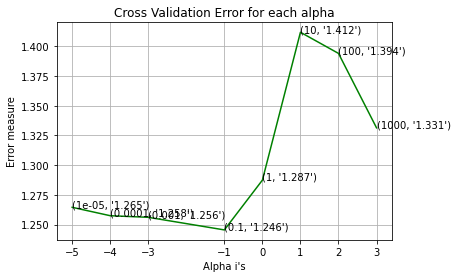

In [105]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [106]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.1 The train log loss is: 0.8555415550920374
For values of best alpha =  0.1 The cross validation log loss is: 1.2455465734799718
For values of best alpha =  0.1 The test log loss is: 1.3309465869312795


Testing our Naive Bayes model with best found value of alpha on testing data

Log Loss : 1.2455465734799718
Number of missclassified point : 0.3890977443609023
-------------------- Confusion matrix --------------------


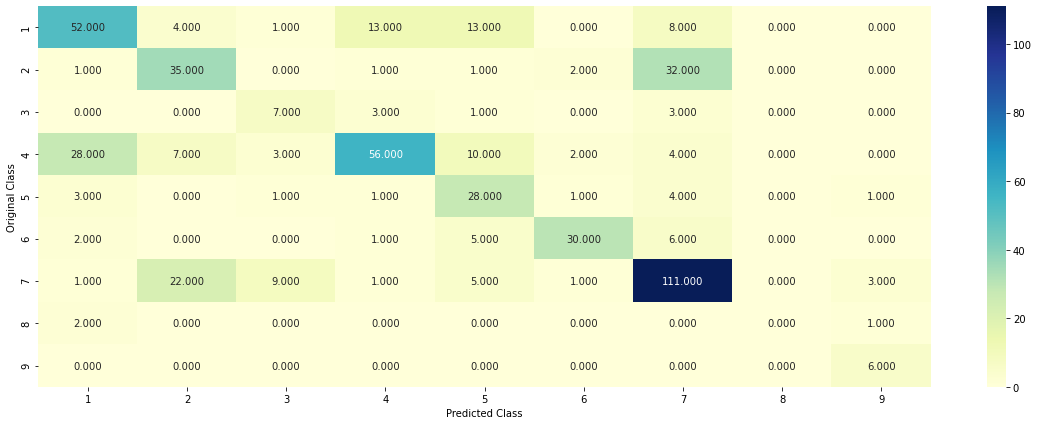

-------------------- Precision matrix (Columm Sum=1) --------------------


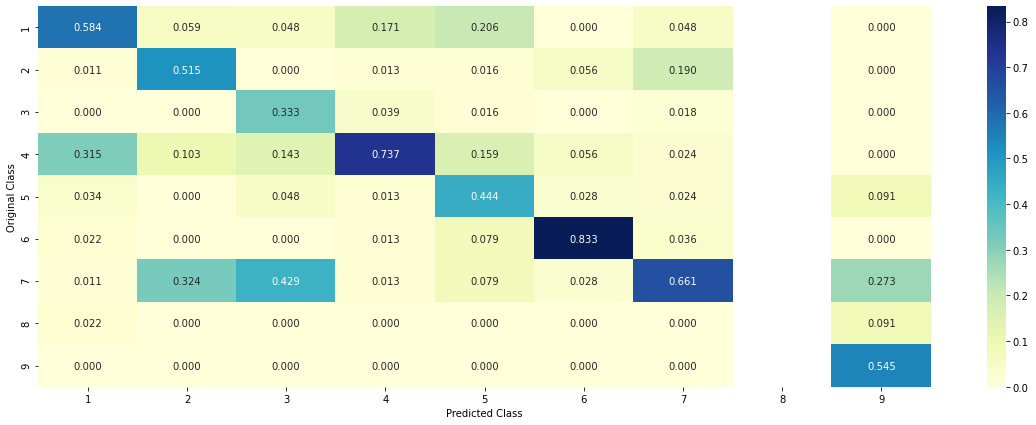

-------------------- Recall matrix (Row sum=1) --------------------


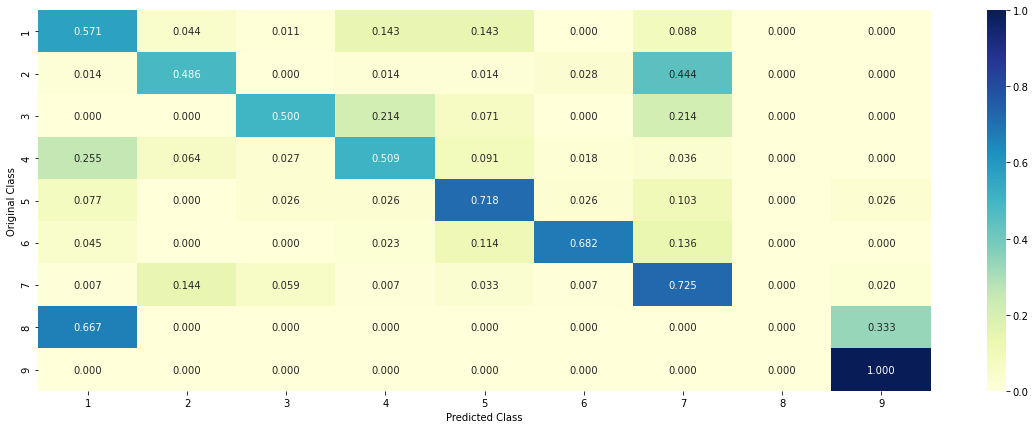

In [107]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

Interpretability of our model

In [109]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)


Predicted Class : 7
Predicted Class Probabilities: [[0.0793 0.0689 0.0121 0.0884 0.0343 0.0374 0.6691 0.0055 0.0051]]
Actual Class : 7
--------------------------------------------------
17 Text feature [kinase] present in test data point [True]
18 Text feature [presence] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
20 Text feature [activating] present in test data point [True]
21 Text feature [previously] present in test data point [True]
22 Text feature [well] present in test data point [True]
23 Text feature [cell] present in test data point [True]
24 Text feature [inhibitor] present in test data point [True]
25 Text feature [obtained] present in test data point [True]
26 Text feature [cells] present in test data point [True]
27 Text feature [potential] present in test data point [True]
30 Text feature [contrast] present in test data point [True]
32 Text feature [recently] present in test data point [True]
33 Text feature [shown] pr

Lets look at one more point

In [110]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1155 0.1362 0.1713 0.1306 0.0488 0.0547 0.327  0.0079 0.0079]]
Actual Class : 7
--------------------------------------------------
17 Text feature [kinase] present in test data point [True]
18 Text feature [presence] present in test data point [True]
19 Text feature [downstream] present in test data point [True]
20 Text feature [activating] present in test data point [True]
21 Text feature [previously] present in test data point [True]
22 Text feature [well] present in test data point [True]
23 Text feature [cell] present in test data point [True]
24 Text feature [inhibitor] present in test data point [True]
25 Text feature [obtained] present in test data point [True]
26 Text feature [cells] present in test data point [True]
27 Text feature [potential] present in test data point [True]
28 Text feature [independent] present in test data point [True]
29 Text feature [showed] present in test data point [True]
32 Text feature [recently

# K Nearest Neighbour Classification

In [111]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.0860978875353966
for alpha = 11
Log Loss : 1.0677389331640939
for alpha = 15
Log Loss : 1.0627603353230752
for alpha = 21
Log Loss : 1.0689228066744452
for alpha = 31
Log Loss : 1.0900601519287825
for alpha = 41
Log Loss : 1.1067164651580763
for alpha = 51
Log Loss : 1.1058334490407966
for alpha = 99
Log Loss : 1.129284560515976


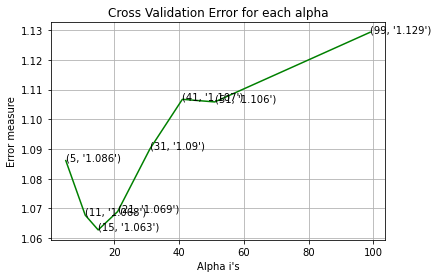

In [112]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [113]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  15 The train log loss is: 0.679543227895721
For values of best alpha =  15 The cross validation log loss is: 1.0627603353230752
For values of best alpha =  15 The test log loss is: 1.0868731025691485


Let's test it on testing dataset with our best alpha value

Log loss : 1.0627603353230752
Number of mis-classified points : 0.37781954887218044
-------------------- Confusion matrix --------------------


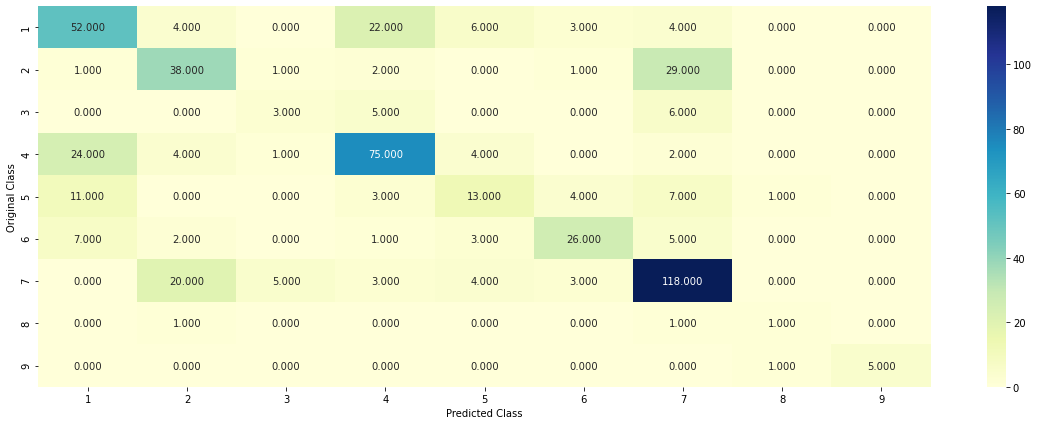

-------------------- Precision matrix (Columm Sum=1) --------------------


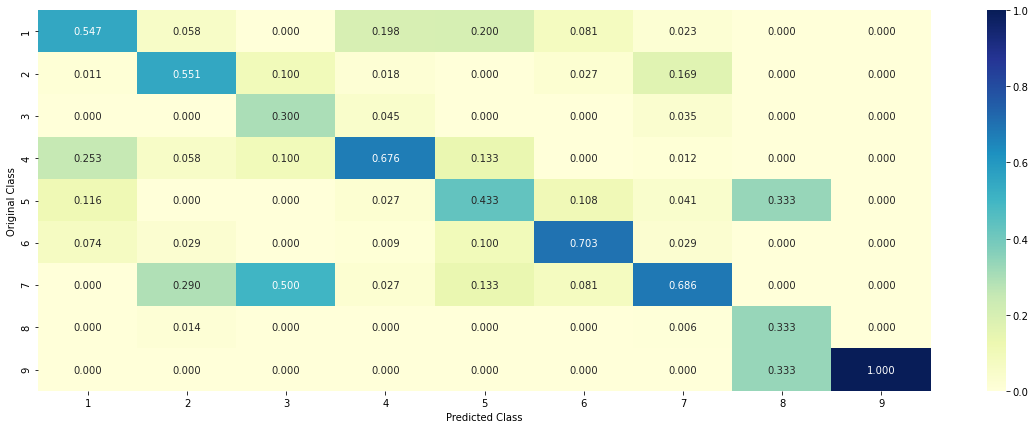

-------------------- Recall matrix (Row sum=1) --------------------


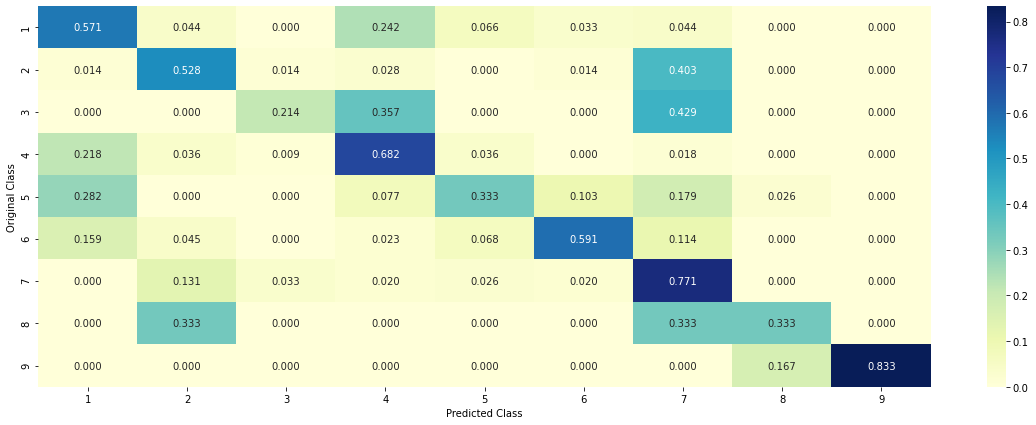

In [114]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [115]:
# Lets look at few test points
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 7
The  15  nearest neighbours of the test points belongs to classes [7 7 3 3 3 3 3 7 7 3 3 7 7 7 7]
Fequency of nearest points : Counter({7: 8, 3: 7})


In [116]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
the k value for knn is 15 and the nearest neighbours of the test points belongs to classes [2 2 3 7 7 7 7 7 7 7 7 5 7 7 7]
Fequency of nearest points : Counter({7: 11, 2: 2, 3: 1, 5: 1})


# Logistic Regression

### Balancing all classes

In [118]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.3642412615674584
for alpha = 1e-05
Log Loss : 1.3266082696224033
for alpha = 0.0001
Log Loss : 1.1145433907332887
for alpha = 0.001
Log Loss : 1.0855320200159244
for alpha = 0.01
Log Loss : 1.13370556916378
for alpha = 0.1
Log Loss : 1.3786897375935716
for alpha = 1
Log Loss : 1.6349369105584386
for alpha = 10
Log Loss : 1.6704000300166593
for alpha = 100
Log Loss : 1.6742244339289738


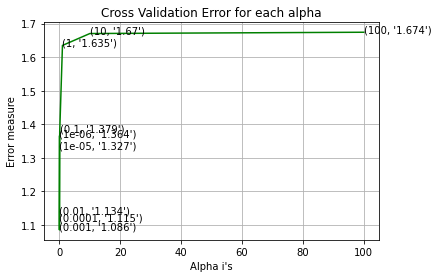

In [119]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [120]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5162074711801234
For values of best alpha =  0.001 The cross validation log loss is: 1.0855320200159244
For values of best alpha =  0.001 The test log loss is: 1.1308497908437372


Log loss : 1.0855320200159244
Number of mis-classified points : 0.34962406015037595
-------------------- Confusion matrix --------------------


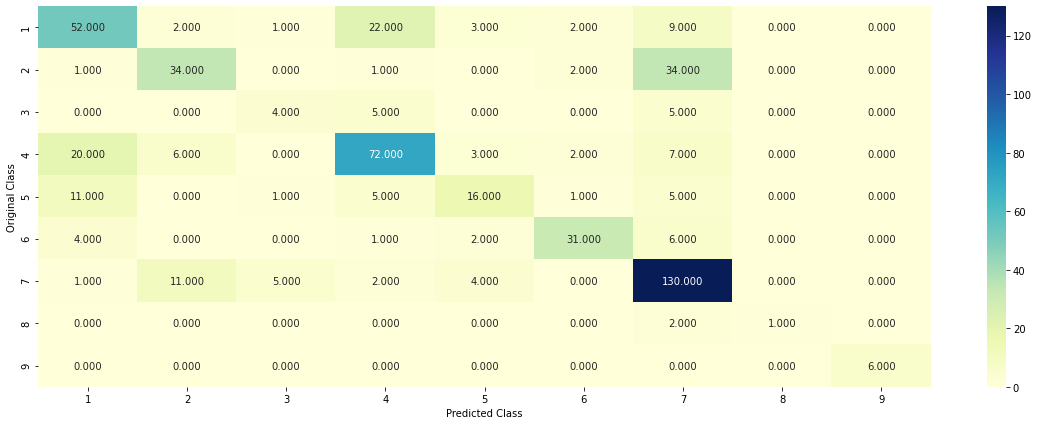

-------------------- Precision matrix (Columm Sum=1) --------------------


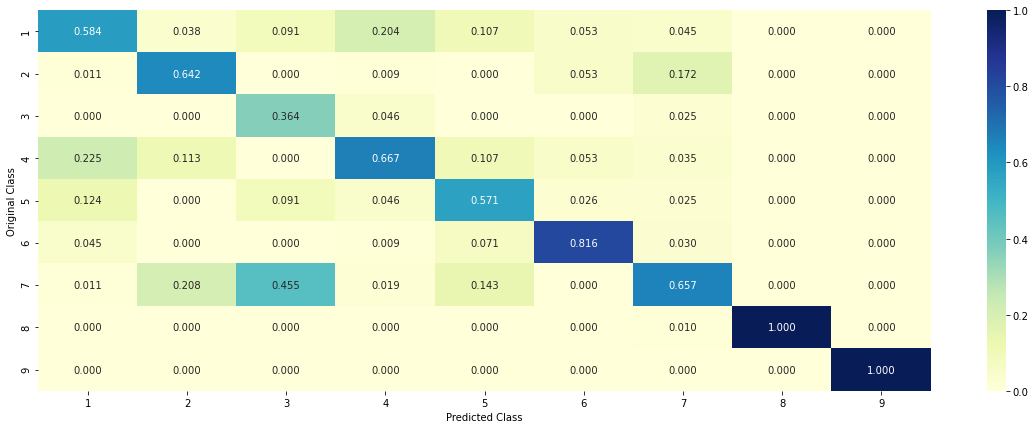

-------------------- Recall matrix (Row sum=1) --------------------


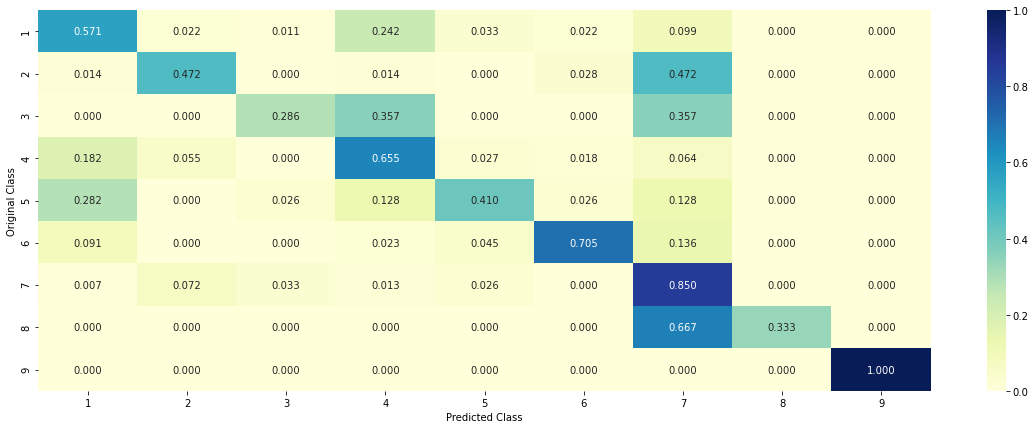

In [121]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

### Feature importance

In [122]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

testing query point and doing interpretability

In [123]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0481 0.1184 0.0187 0.0315 0.0372 0.0262 0.7076 0.0065 0.0059]]
Actual Class : 7
--------------------------------------------------
29 Text feature [constitutive] present in test data point [True]
32 Text feature [constitutively] present in test data point [True]
165 Text feature [downstream] present in test data point [True]
251 Text feature [activation] present in test data point [True]
321 Text feature [activating] present in test data point [True]
334 Text feature [akt] present in test data point [True]
Out of the top  500  features  6 are present in query point


In [124]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0291 0.2831 0.0866 0.0319 0.0256 0.0198 0.5099 0.0076 0.0064]]
Actual Class : 7
--------------------------------------------------
29 Text feature [constitutive] present in test data point [True]
165 Text feature [downstream] present in test data point [True]
168 Text feature [phosphotyrosine] present in test data point [True]
251 Text feature [activation] present in test data point [True]
295 Text feature [interleukin] present in test data point [True]
296 Text feature [ligand] present in test data point [True]
310 Text feature [tk1] present in test data point [True]
315 Text feature [murine] present in test data point [True]
321 Text feature [activating] present in test data point [True]
348 Text feature [progressed] present in test data point [True]
369 Text feature [ba] present in test data point [True]
373 Text feature [f3] present in test data point [True]
Out of the top  500  features  12 are present in query point


## Without class balancing

In [125]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.3187902319500886
for alpha = 1e-05
Log Loss : 1.2804984138099347
for alpha = 0.0001
Log Loss : 1.1365214567063433
for alpha = 0.001
Log Loss : 1.0960127295339008
for alpha = 0.01
Log Loss : 1.1728233827593557
for alpha = 0.1
Log Loss : 1.3613755190956085
for alpha = 1
Log Loss : 1.550677647523555


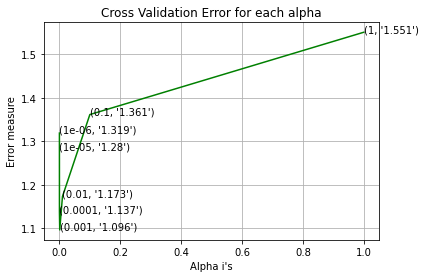

In [126]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [127]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5216274291553603
For values of best alpha =  0.001 The cross validation log loss is: 1.0960127295339008
For values of best alpha =  0.001 The test log loss is: 1.1413704355704162


Log loss : 1.0960127295339008
Number of mis-classified points : 0.34774436090225563
-------------------- Confusion matrix --------------------


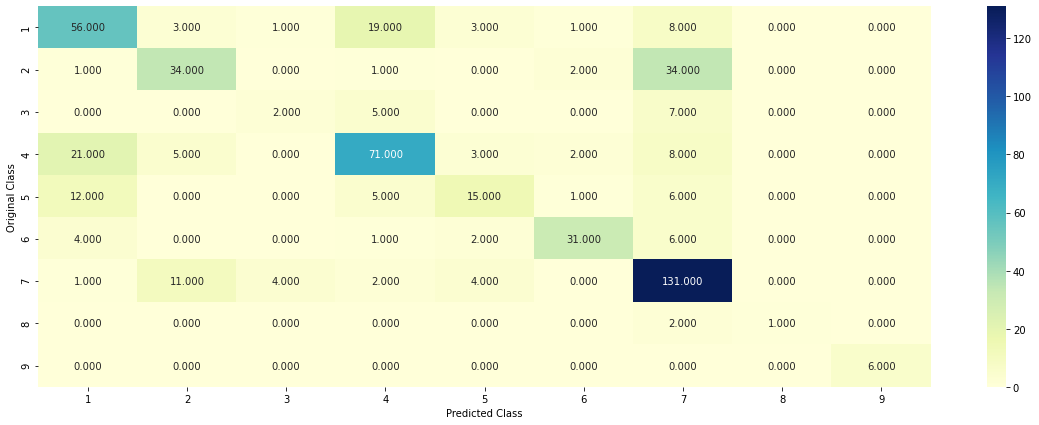

-------------------- Precision matrix (Columm Sum=1) --------------------


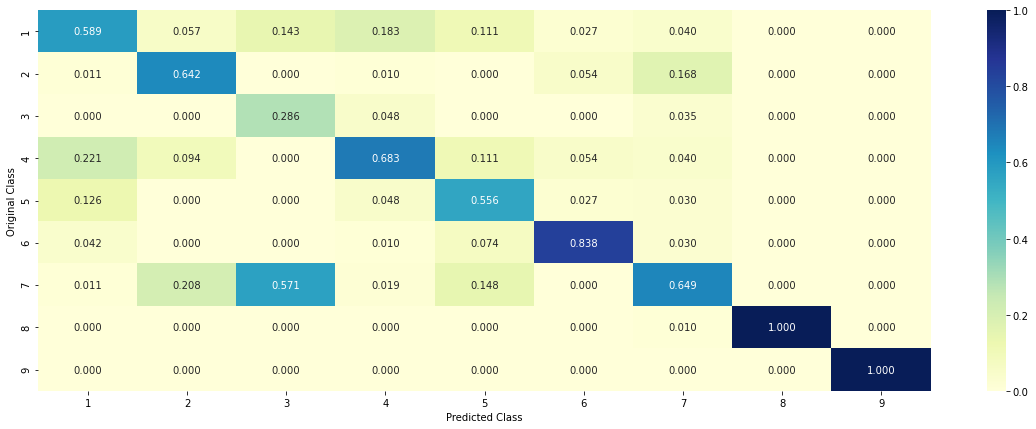

-------------------- Recall matrix (Row sum=1) --------------------


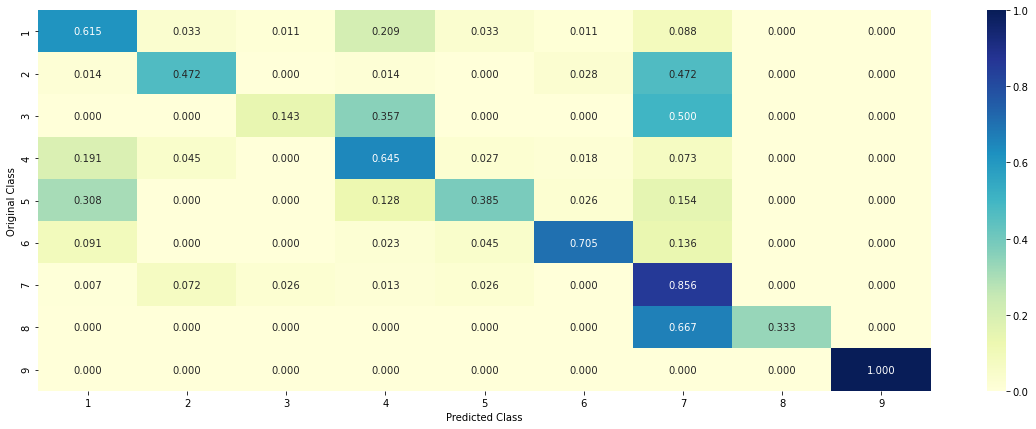

In [128]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

## Testing query point and interpretability

In [129]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0464 0.1146 0.0205 0.0301 0.0371 0.0265 0.7129 0.0064 0.0055]]
Actual Class : 7
--------------------------------------------------
107 Text feature [constitutively] present in test data point [True]
109 Text feature [constitutive] present in test data point [True]
319 Text feature [downstream] present in test data point [True]
343 Text feature [activating] present in test data point [True]
368 Text feature [stiffness] present in test data point [True]
427 Text feature [activation] present in test data point [True]
473 Text feature [akt] present in test data point [True]
Out of the top  500  features  7 are present in query point


# Linear Support Vector Machines

for C = 1e-05
Log Loss : 1.3491040735121447
for C = 0.0001
Log Loss : 1.24776453886593
for C = 0.001
Log Loss : 1.1312233683149577
for C = 0.01
Log Loss : 1.1400700232726886
for C = 0.1
Log Loss : 1.3142089133904733
for C = 1
Log Loss : 1.6578589906810017
for C = 10
Log Loss : 1.6748179829291763
for C = 100
Log Loss : 1.6748180199112397


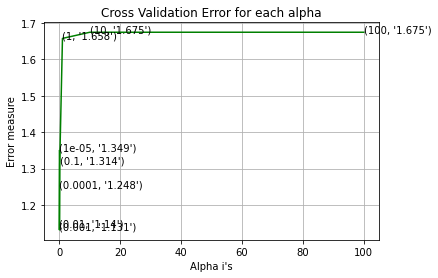

For values of best alpha =  0.001 The train log loss is: 0.5281319271614562
For values of best alpha =  0.001 The cross validation log loss is: 1.1312233683149577
For values of best alpha =  0.001 The test log loss is: 1.1694113204483296


In [130]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## Testing model with best alpha values

Log loss : 1.1312233683149577
Number of mis-classified points : 0.3533834586466165
-------------------- Confusion matrix --------------------


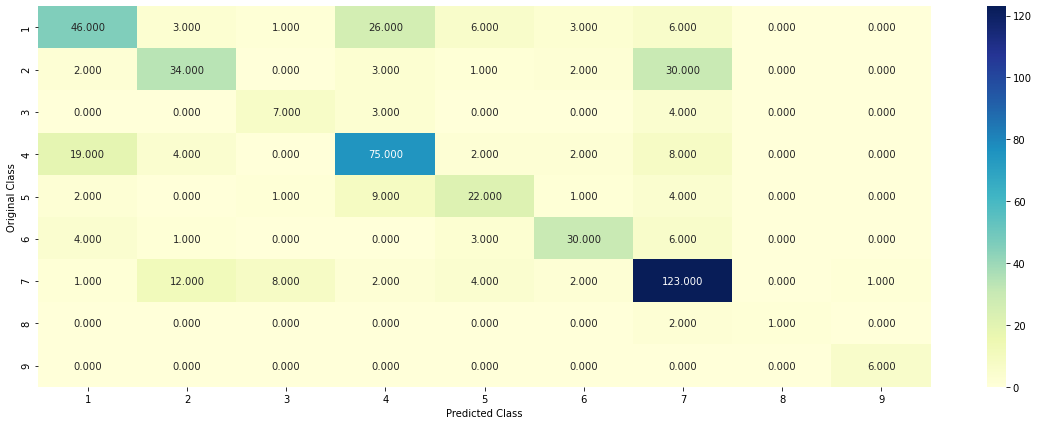

-------------------- Precision matrix (Columm Sum=1) --------------------


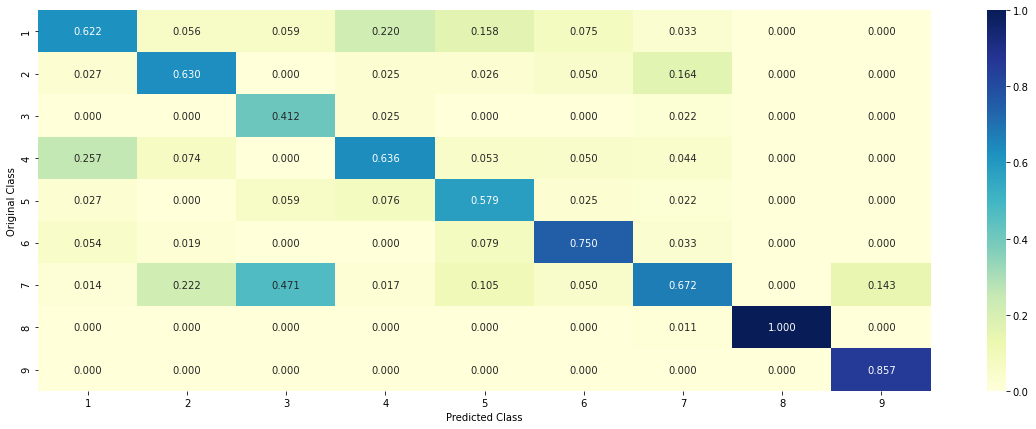

-------------------- Recall matrix (Row sum=1) --------------------


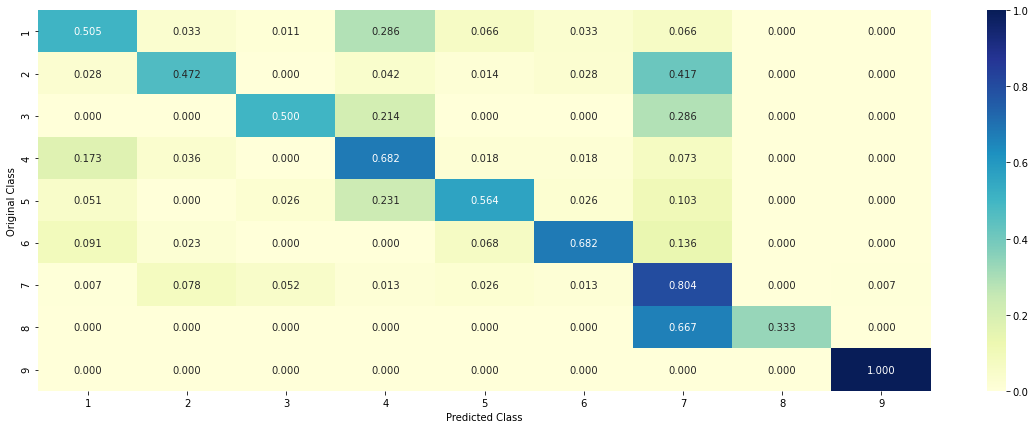

In [131]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

Querying some correctly classified point

In [132]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.084  0.0718 0.0136 0.0533 0.0473 0.0317 0.6859 0.0061 0.0063]]
Actual Class : 7
--------------------------------------------------
351 Text feature [stiffness] present in test data point [True]
410 Text feature [constitutively] present in test data point [True]
474 Text feature [constitutive] present in test data point [True]
Out of the top  500  features  3 are present in query point


# Random Forest Classifier

## Model with One hot encoder

In [133]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 1.215620829361074
for n_estimators = 100 and max depth =  10
Log Loss : 1.1267911516269478
for n_estimators = 200 and max depth =  5
Log Loss : 1.2068519278648122
for n_estimators = 200 and max depth =  10
Log Loss : 1.122247143079571
for n_estimators = 500 and max depth =  5
Log Loss : 1.193740074954324
for n_estimators = 500 and max depth =  10
Log Loss : 1.1156161546288805
for n_estimators = 1000 and max depth =  5
Log Loss : 1.193244796403511
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1128364910513966
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1932633987058823
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1120315297961476


In [134]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  2000 The train log loss is: 0.6839960545903773
For values of best estimator =  2000 The cross validation log loss is: 1.1120315297961476
For values of best estimator =  2000 The test log loss is: 1.1671994557027243


Lets test it on testing data using best hyper param

Log loss : 1.1120315297961476
Number of mis-classified points : 0.39473684210526316
-------------------- Confusion matrix --------------------


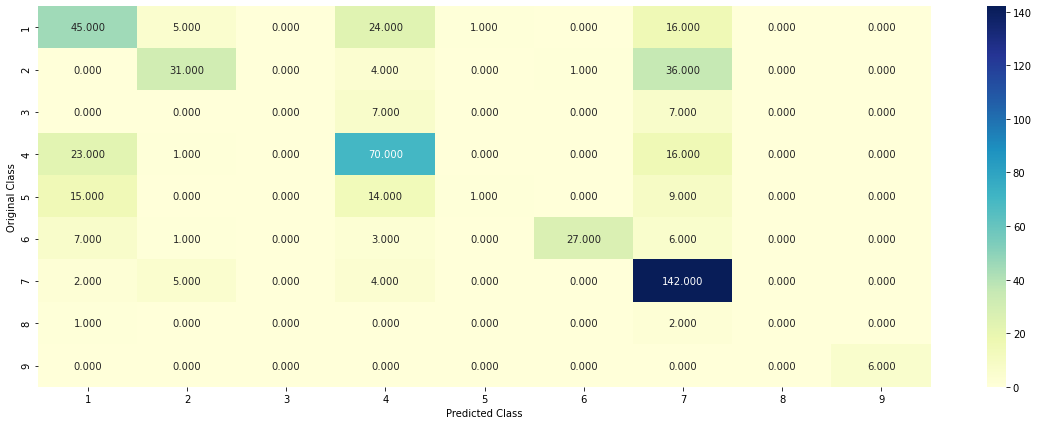

-------------------- Precision matrix (Columm Sum=1) --------------------


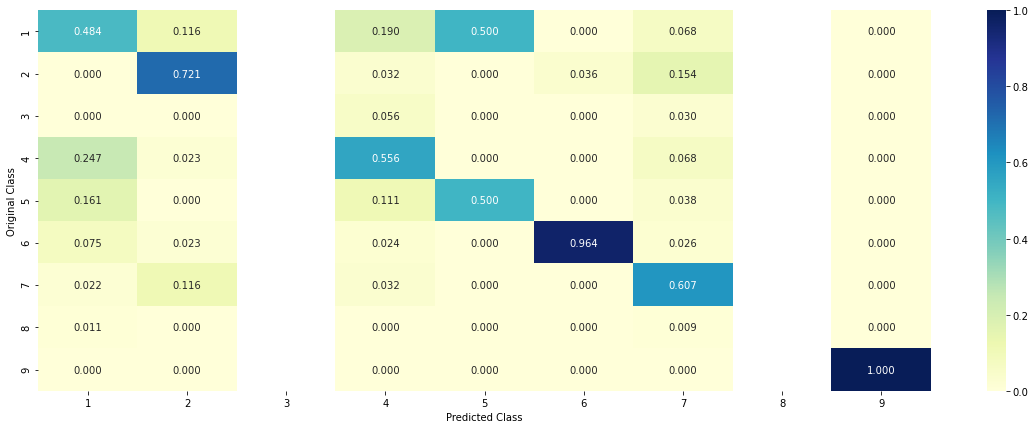

-------------------- Recall matrix (Row sum=1) --------------------


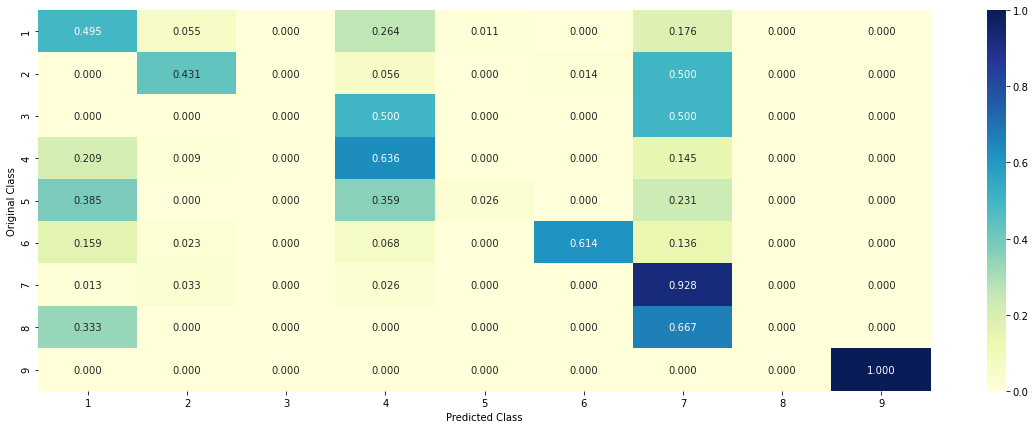

In [135]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [136]:
# test_point_index = 10
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0573 0.3279 0.0195 0.0495 0.0432 0.039  0.4519 0.006  0.0057]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [activation] present in test data point [True]
3 Text feature [inhibitors] present in test data point [True]
4 Text feature [tyrosine] present in test data point [True]
5 Text feature [phosphorylation] present in test data point [True]
7 Text feature [missense] present in test data point [True]
8 Text feature [constitutive] present in test data point [True]
9 Text feature [treatment] present in test data point [True]
10 Text feature [inhibitor] present in test data point [True]
11 Text feature [suppressor] present in test data point [True]
12 Text feature [signaling] present in test data point [True]
14 Text feature [akt] present in test data point [True]
16 Text feature

## RF with Response Coding

In [137]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 2.120143791865433
for n_estimators = 10 and max depth =  3
Log Loss : 1.7213691903280477
for n_estimators = 10 and max depth =  5
Log Loss : 1.4131818709809494
for n_estimators = 10 and max depth =  10
Log Loss : 1.9349454359891365
for n_estimators = 50 and max depth =  2
Log Loss : 1.6249288963093247
for n_estimators = 50 and max depth =  3
Log Loss : 1.416078838726194
for n_estimators = 50 and max depth =  5
Log Loss : 1.3375772904937762
for n_estimators = 50 and max depth =  10
Log Loss : 1.8193089127904853
for n_estimators = 100 and max depth =  2
Log Loss : 1.5248853160881706
for n_estimators = 100 and max depth =  3
Log Loss : 1.4745084649703262
for n_estimators = 100 and max depth =  5
Log Loss : 1.3515306644797938
for n_estimators = 100 and max depth =  10
Log Loss : 1.7595519183560007
for n_estimators = 200 and max depth =  2
Log Loss : 1.5645392327255452
for n_estimators = 200 and max depth =  3
Log Loss : 1.4336626237601897

Testing model with best hyper param

Log loss : 1.337577818225439
Number of mis-classified points : 0.4755639097744361
-------------------- Confusion matrix --------------------


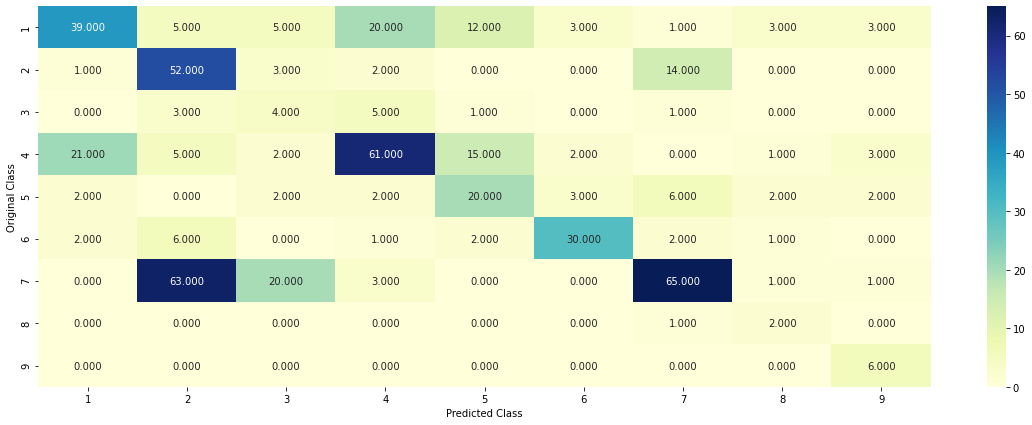

-------------------- Precision matrix (Columm Sum=1) --------------------


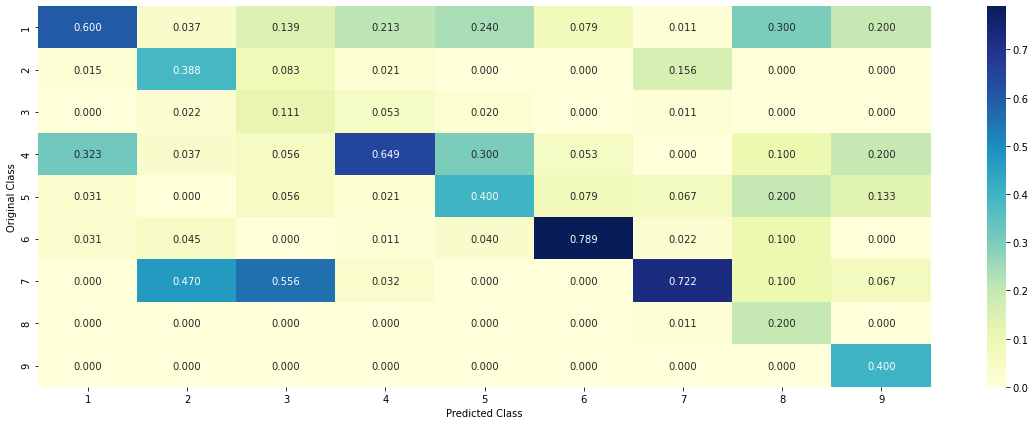

-------------------- Recall matrix (Row sum=1) --------------------


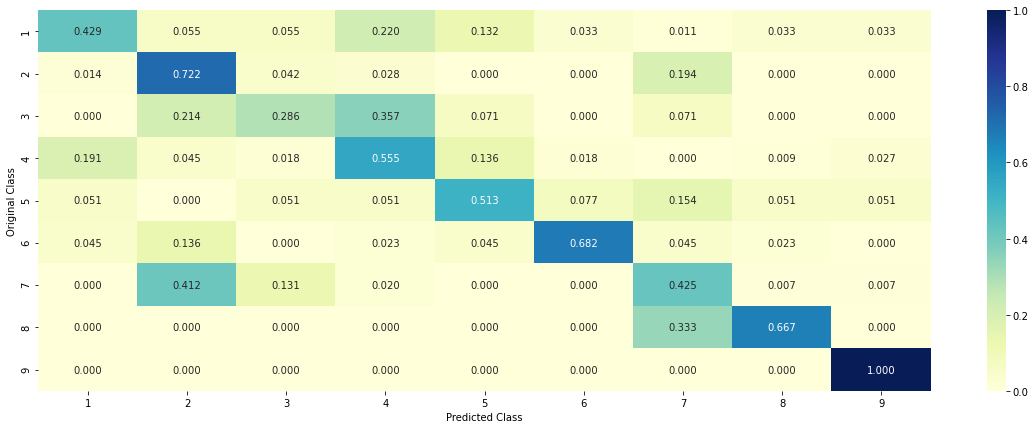

In [138]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

Query the classified point

In [139]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.0151 0.2739 0.2229 0.021  0.0421 0.0443 0.3223 0.0437 0.0146]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Gene is important feature
Text is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Gene is important feature


## Stacking model

In [140]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.09
Support vector machines : Log Loss: 1.66
Naive Bayes : Log Loss: 1.26
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.818
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.724
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.344
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.193
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.462
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.831


Testing with best hyper param

Log loss (train) on the stacking classifier : 0.5019576998254572
Log loss (CV) on the stacking classifier : 1.1930148370157039
Log loss (test) on the stacking classifier : 1.222796775607967
Number of missclassified point : 0.3804511278195489
-------------------- Confusion matrix --------------------


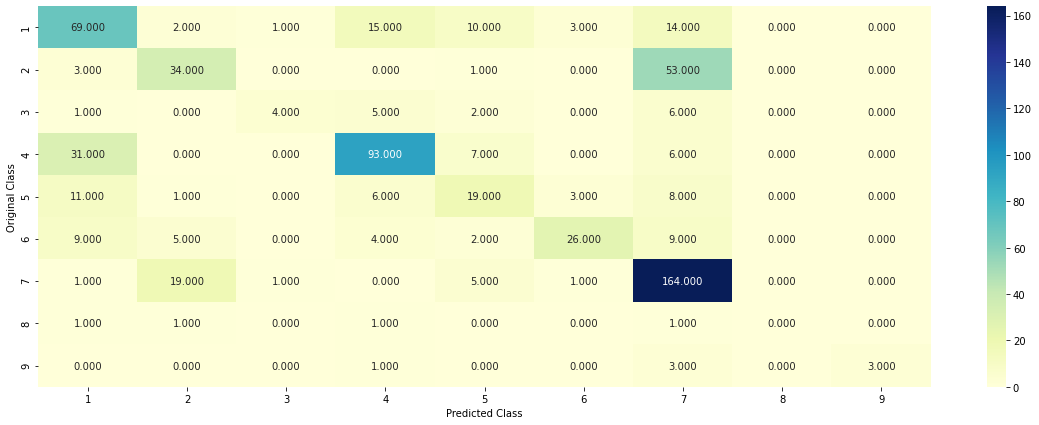

-------------------- Precision matrix (Columm Sum=1) --------------------


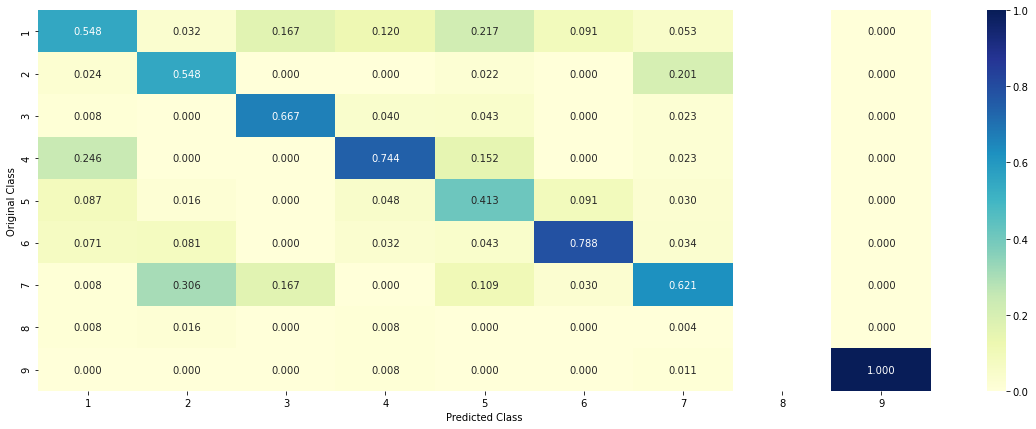

-------------------- Recall matrix (Row sum=1) --------------------


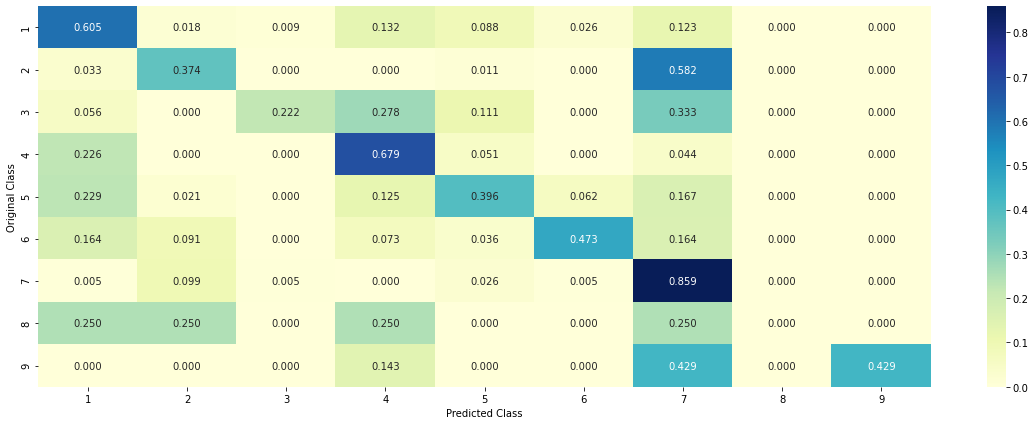

In [141]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## Maximum voting Classifier

Log loss (train) on the VotingClassifier : 0.8588384283572337
Log loss (CV) on the VotingClassifier : 1.161423781595183
Log loss (test) on the VotingClassifier : 1.2340132993323356
Number of missclassified point : 0.37894736842105264
-------------------- Confusion matrix --------------------


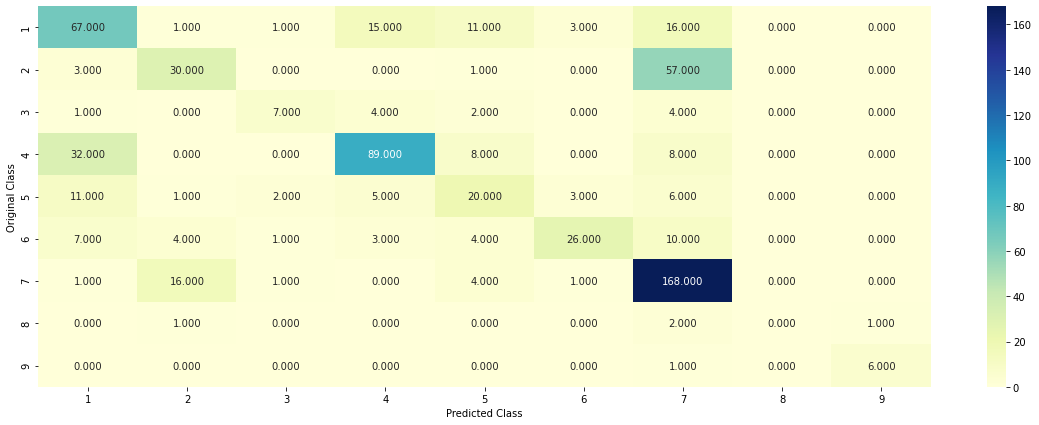

-------------------- Precision matrix (Columm Sum=1) --------------------


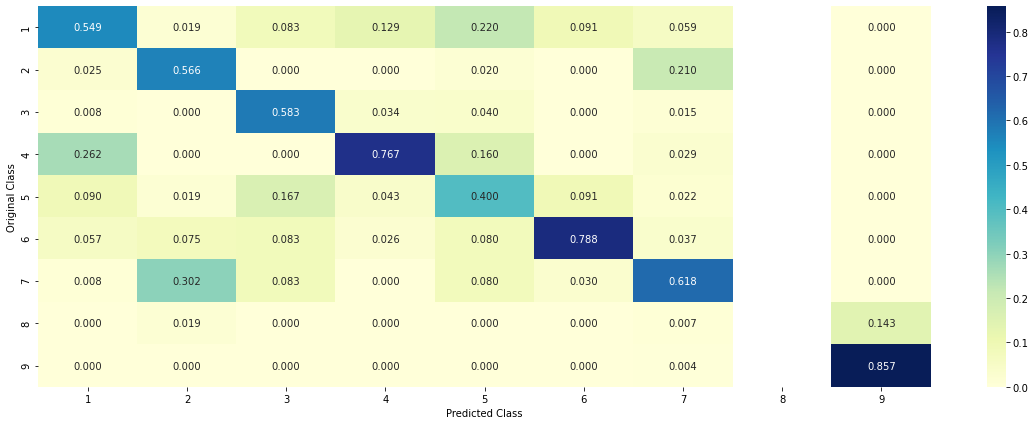

-------------------- Recall matrix (Row sum=1) --------------------


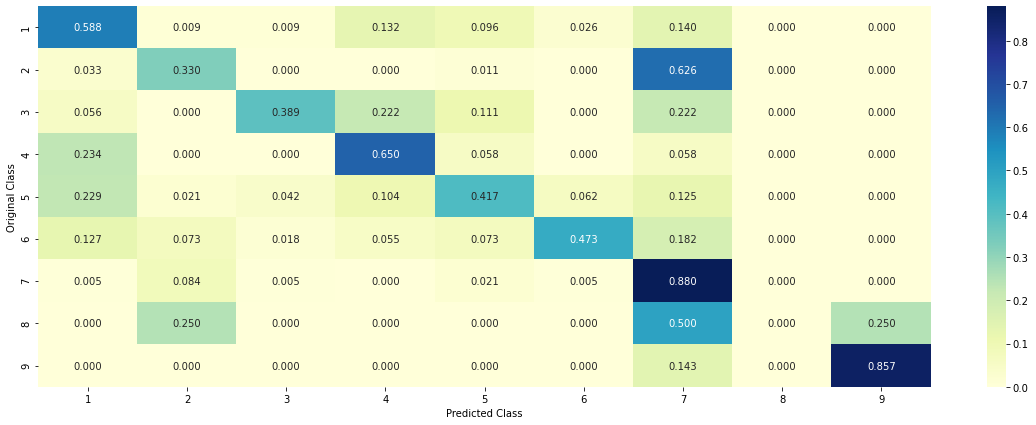

In [142]:
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))
